
---
🌟🌟🌟 欢迎来到哈罗德的量化频道！🌟🌟🌟

### 因子实战 第八集 
### 因子回测 Backtesting 系列：一个好因子的标准(1)
# IC & RankIC

### 🎬 主讲：大导演哈罗德
- 🏛 香港中文大学(深圳) 金融工程 本科
- 📈 即将前往美国金融工程硕士之路（已经获得录取）
- 🌐 [关注我的Bilibili，看所有人都能听得懂的量化学习内容！](https://space.bilibili.com/629573485)
- 📚 [关注我的YouTube，看更多量化投资干货！](https://www.youtube.com/@BD_Harold)
- 📱 微信公众号：大导演哈罗德，微信公众号：大导演哈罗德；所有的数据都可以在这个获取～

🌟🌟🌟 我有一个梦想，就是让量化变成不再是束之高阁的灵丹妙药，而是让散户投资者认识市场风险最好的工具 @哈罗德的量化频道 🌟🌟🌟

---

In [12]:
"""
我们先跳过这一个框框的代码，先看下一个框框的代码。
这个框框的代码是用来导入数据的和因子回测的方程的。
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from 因子回测包 import factor_correlation as FactorIC
from 因子回测包 import factor_group as FactorGroup

sw_ind = pd.read_pickle('数据/IndexComponent_SWN_I.txt')
stock_close = pd.read_pickle('数据/StockQuote_ClosePrice_BackwardAdj.txt')
stock_open = pd.read_pickle('数据/StockQuote_OpenPrice_BackwardAdj.txt')
monthly_trading_day = pd.read_pickle('数据/monthly_trading_day.pkl')
monthly_trading_day['start_date'] = pd.to_datetime(monthly_trading_day['start_date'], format='%Y%m%d')
monthly_trading_day['end_date'] = pd.to_datetime(monthly_trading_day['end_date'], format='%Y%m%d')
start_date = pd.to_datetime('20120101', format='%Y%m%d')
end_date = pd.to_datetime('20231231', format='%Y%m%d')
filtered_trading_days = monthly_trading_day.loc[(monthly_trading_day['end_date'] >= start_date) & (monthly_trading_day['end_date'] <= end_date)]
stock_close.index = pd.to_datetime(stock_close.index)
stock_open.index = pd.to_datetime(stock_open.index)
stock_ret_monthly = stock_close.reindex(index = filtered_trading_days.end_date).pct_change() 
stock_ret_monthly_nextopen = stock_open.shift(-1).reindex(filtered_trading_days.end_date).pct_change()

def simple_factor_test(factor,use_data = 'this_close'):
    if use_data=='this_close':
        # 
        this_ret_data = stock_ret_monthly.shift(-1)
    else: 
        this_ret_data = stock_ret_monthly_nextopen.shift(-1)

    ic,rankic = FactorIC(factor,this_ret_data)
    factor_group = FactorGroup(factor)
    condata = pd.concat([factor_group.unstack(),this_ret_data.unstack()],axis=1).dropna().reset_index()
    condata.columns =['stockcode','date','group_id','ret']
    group_ret = condata.groupby(['date','group_id'])['ret'].mean().unstack()
    return ic,rankic,group_ret

pe = pd.read_pickle('数据/StockQuote_PEttm.txt')
ep = 1/pe
ep.replace(np.inf, np.nan, inplace = True) #  计算EPttm并去除无限大的值
ep.replace(-np.inf, np.nan, inplace = True) #  计算EPttm并去除无限大的值
dEP = ep.diff(60) # dEP因子是EP因子的六十日delta
# 回测周期：2012-01-01至2023-12-31
# change index into datetime
dEP.index = pd.to_datetime(dEP.index)
dEP_monthly = dEP.reindex(index = filtered_trading_days.end_date) # 按月抽样得到dEP的因子值

ic,rankic,group_ret  = simple_factor_test(dEP_monthly)


In [13]:
ic

end_date
2012-01-31    0.152079
2012-02-29    0.049345
2012-03-30   -0.024677
2012-04-27    0.082740
2012-05-31    0.086493
                ...   
2023-07-31   -0.011495
2023-08-31   -0.010935
2023-09-28   -0.070958
2023-10-31   -0.014430
2023-11-30         NaN
Length: 143, dtype: float64

In [16]:
rankic

end_date
2012-01-31    0.155546
2012-02-29    0.093055
2012-03-30   -0.081518
2012-04-27    0.086904
2012-05-31    0.161245
                ...   
2023-07-31   -0.016382
2023-08-31    0.023169
2023-09-28   -0.155764
2023-10-31   -0.075455
2023-11-30         NaN
Length: 143, dtype: float64

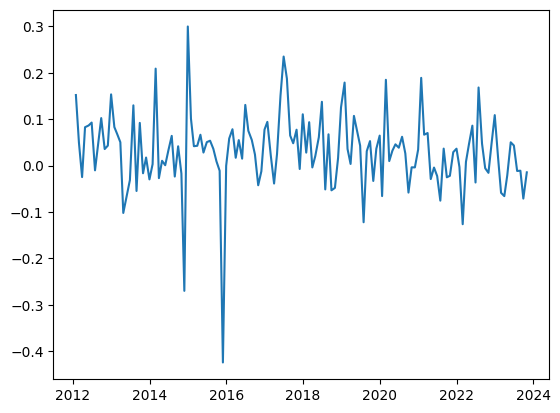

In [15]:
plt.plot(ic)

**IC 即 信息系数（Information Coefficient），表示所选股票的因子值与股票下期收益率的截面相关系数，通过 IC 值可以判断因子值对下期收益率的预测能力。**

信息系数（Information Coefficient, IC）是量化投资中用来衡量股票选择因子（如财务比率、市场数据等）预测能力的一个关键指标。它衡量的是因子值与股票未来收益之间的线性相关程度。简单来说，IC值帮助投资者理解某个因子在预测股票表现方面的有效性。IC值的范围从-1到1，其中：

- IC值为1表示因子值与股票未来收益完全正相关；
- IC值为-1表示因子值与股票未来收益完全负相关；
- IC值为0表示因子值与股票未来收益没有相关性。



Rank_IC的计算通常通过以下步骤进行：

对于每个股票，根据选定因子计算其因子值。
将所有股票根据因子值进行排名。
在下一个调仓周期结束时，计算所有股票的实际收益率，并进行排名。
计算步骤2和步骤3中得到的两个排名序列之间的Spearman等级相关系数，即为Rank_IC值。

例子
假设我们正在研究市盈率（PE）作为一个因子来预测股票未来一期的收益。我们首先根据市盈率对股票进行排名，然后在下一个调仓周期结束时观察这些股票的实际收益并进行排名。如果我们计算得到的IC值为0.05，这意味着市盈率与股票未来收益正相关，且相关性较弱但仍具有一定的预测能力。如果我们设定的有效IC阈值为0.03，那么在这个例子中，市盈率可以被认为是一个有用的选股因子。

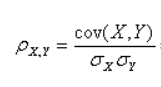

In [17]:
dEP_monthly

,000001.SZ,000002.SZ,000003.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,...,873570.BJ,873576.BJ,873593.BJ,873665.BJ,873679.BJ,873693.BJ,873703.BJ,873726.BJ,873833.BJ,T00018.SH
end_date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,0.002481,0.002968,NaN,-0.005549,-0.000836,0.003023,0.001183,0.000250,0.003496,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-29,-0.008819,-0.014278,NaN,0.000517,0.000000,-0.048998,-0.006231,0.000168,0.006528,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-30,0.009866,0.011612,NaN,-0.000039,0.000000,-0.075154,-0.010442,NaN,0.002593,0.000081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-27,0.024902,0.009117,NaN,0.000090,-0.011260,-0.026038,-0.008362,NaN,-0.005099,0.003222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-31,0.035999,0.013286,NaN,0.000321,-0.011072,-0.006224,-0.000973,NaN,-0.006213,0.003018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,0.000320,-0.006076,NaN,NaN,NaN,-0.005207,NaN,NaN,-0.001222,NaN,...,NaN,NaN,-0.002515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31,0.011596,-0.010884,NaN,NaN,NaN,-0.030556,NaN,NaN,0.005729,NaN,...,NaN,NaN,0.009349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-28,0.016771,0.002706,NaN,NaN,NaN,-0.021728,NaN,NaN,0.004374,NaN,...,NaN,0.011647,0.005304,NaN,NaN,NaN,NaN,NaN,NaN,NaN


矩阵 M*N
- M 为时间周期(月度) 143
- N 为股票数量 5543

corr(因子值, 下期收益率) = IC （ 143*1 的向量 ）


In [18]:
stock_ret_monthly

,000001.SZ,000002.SZ,000003.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,...,873570.BJ,873576.BJ,873593.BJ,873665.BJ,873679.BJ,873693.BJ,873703.BJ,873726.BJ,873833.BJ,T00018.SH
end_date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-29,0.027644,0.082353,NaN,0.140266,0.000000,0.200456,0.309558,0.099715,-0.045736,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-30,-0.081287,0.000000,NaN,-0.137858,0.000000,0.045541,0.257081,0.215026,-0.176279,-0.301435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-27,0.054106,0.084541,NaN,0.049200,0.028497,0.152450,-0.004333,-0.068230,0.096647,0.163405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-31,-0.052536,0.030067,NaN,0.100821,-0.110831,-0.036220,0.366406,0.160183,0.028777,0.063919,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,0.097061,0.087732,NaN,0.169836,0.086614,0.169336,0.067114,0.038136,-0.045568,0.381579,...,NaN,0.257511,-0.355322,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31,-0.096591,-0.059618,NaN,-0.076794,0.021739,0.023483,0.064990,-0.036735,-0.072213,0.025397,...,NaN,-0.209898,-0.098837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-28,0.006289,-0.041056,NaN,-0.026715,0.028369,-0.131931,-0.114173,0.033898,-0.022514,0.092879,...,NaN,-0.054723,-0.057787,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
stock_ret_monthly.shift(-1)

,000001.SZ,000002.SZ,000003.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,...,873570.BJ,873576.BJ,873593.BJ,873665.BJ,873679.BJ,873693.BJ,873703.BJ,873726.BJ,873833.BJ,T00018.SH
end_date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,0.027644,0.082353,NaN,0.140266,0.000000,0.200456,0.309558,0.099715,-0.045736,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-29,-0.081287,0.000000,NaN,-0.137858,0.000000,0.045541,0.257081,0.215026,-0.176279,-0.301435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-30,0.054106,0.084541,NaN,0.049200,0.028497,0.152450,-0.004333,-0.068230,0.096647,0.163405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-27,-0.052536,0.030067,NaN,0.100821,-0.110831,-0.036220,0.366406,0.160183,0.028777,0.063919,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-31,-0.033779,-0.036757,NaN,-0.097977,-0.147309,-0.066993,-0.054777,0.127219,-0.125874,0.090909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,-0.096591,-0.059618,NaN,-0.076794,0.021739,0.023483,0.064990,-0.036735,-0.072213,0.025397,...,NaN,-0.209898,-0.098837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31,0.006289,-0.041056,NaN,-0.026715,0.028369,-0.131931,-0.114173,0.033898,-0.022514,0.092879,...,NaN,-0.054723,-0.057787,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-28,-0.066071,-0.133792,NaN,0.082346,-0.020690,-0.048458,0.115556,-0.032787,-0.008637,0.161473,...,0.000000,0.114625,-0.275929,-0.032313,NaN,NaN,NaN,NaN,0.000000,NaN


IC

In [20]:
dEP_monthly.corrwith(stock_ret_monthly.shift(-1),axis=1)	

end_date
2012-01-31    0.152079
2012-02-29    0.049345
2012-03-30   -0.024677
2012-04-27    0.082740
2012-05-31    0.086493
                ...   
2023-07-31   -0.011495
2023-08-31   -0.010935
2023-09-28   -0.070958
2023-10-31   -0.014430
2023-11-30         NaN
Length: 143, dtype: float64

In [21]:
dEP_monthly.corrwith(stock_ret_monthly.shift(-1),axis=1).mean()

0.030843641218832464

In [2]:
ic

end_date
2012-01-31    0.152079
2012-02-29    0.049345
2012-03-30   -0.024677
2012-04-27    0.082740
2012-05-31    0.086493
                ...   
2023-07-31   -0.011495
2023-08-31   -0.010935
2023-09-28   -0.070958
2023-10-31   -0.014430
2023-11-30         NaN
Length: 143, dtype: float64

In [22]:
dEP_monthly.rank(axis=1)

,000001.SZ,000002.SZ,000003.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,...,873570.BJ,873576.BJ,873593.BJ,873665.BJ,873679.BJ,873693.BJ,873703.BJ,873726.BJ,873833.BJ,T00018.SH
end_date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,498.0,558.0,NaN,57.0,159.0,567.0,339.0,238.0,633.0,208.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-29,138.0,85.0,NaN,688.0,552.5,7.0,192.0,613.0,1722.0,552.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-30,2007.0,2032.0,NaN,1281.0,1294.0,8.0,344.0,NaN,1633.0,1315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-27,1981.0,1898.0,NaN,1371.0,466.0,153.0,599.0,NaN,840.0,1664.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-31,2013.0,1929.0,NaN,1065.0,253.0,413.0,898.0,NaN,414.0,1467.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,2421.0,278.0,NaN,NaN,NaN,343.0,NaN,NaN,1170.0,NaN,...,NaN,NaN,756.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31,3611.0,368.0,NaN,NaN,NaN,83.0,NaN,NaN,3078.0,NaN,...,NaN,NaN,3478.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-28,3807.0,2458.0,NaN,NaN,NaN,132.0,NaN,NaN,2890.0,NaN,...,NaN,3663.0,3065.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
stock_ret_monthly.shift(-1).rank(axis=1)

,000001.SZ,000002.SZ,000003.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,...,873570.BJ,873576.BJ,873593.BJ,873665.BJ,873679.BJ,873693.BJ,873703.BJ,873726.BJ,873833.BJ,T00018.SH
end_date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,106.0,569.0,NaN,1483.0,43.5,1991.0,2240.0,858.0,4.0,43.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-29,1238.0,1948.5,NaN,445.0,1948.5,2139.0,2307.0,2301.0,155.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-30,1165.0,1514.0,NaN,1101.0,846.0,2008.0,463.0,127.0,1604.0,2059.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-27,303.0,1472.0,NaN,1997.0,54.0,510.0,2348.0,2201.0,1462.0,1784.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-31,1574.0,1539.0,NaN,846.0,321.0,1247.0,1365.0,2253.0,520.0,2188.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,1107.0,2268.0,NaN,1654.0,4546.0,4573.0,4990.0,3044.5,1807.0,4598.0,...,NaN,70.0,1055.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31,3377.0,1286.0,NaN,1743.0,4240.0,179.0,256.0,4382.5,1897.0,5090.0,...,NaN,940.0,879.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-28,1177.0,294.0,NaN,4929.0,2610.0,1648.0,5088.0,2149.5,3058.0,5256.0,...,3452.5,5083.0,15.0,2163.0,NaN,NaN,NaN,NaN,3452.5,NaN


rankic

In [24]:
dEP_monthly.rank(axis=1).corrwith(stock_ret_monthly.shift(-1).rank(axis=1),axis=1)

end_date
2012-01-31    0.155546
2012-02-29    0.093055
2012-03-30   -0.081518
2012-04-27    0.086904
2012-05-31    0.161245
                ...   
2023-07-31   -0.016382
2023-08-31    0.023169
2023-09-28   -0.155764
2023-10-31   -0.075455
2023-11-30         NaN
Length: 143, dtype: float64

In [25]:
dEP_monthly.rank(axis=1).corrwith(stock_ret_monthly.shift(-1).rank(axis=1),axis=1).mean()

0.06006491867172145

In [2]:
group_ret['long_short_returns'] = group_ret[group_ret.columns[4]] - group_ret[group_ret.columns[0]]

avg_return = group_ret['long_short_returns'].mean()
std_deviation = group_ret['long_short_returns'].std()

avg_return_annualized = avg_return * 12  # Assuming monthly returns
std_deviation_annualized = std_deviation * np.sqrt(12)  # Assuming monthly returns

# Sharpe Ratio calculation (assuming the risk-free rate is 0 for simplicity)
sharpe_ratio = avg_return_annualized / std_deviation_annualized

# For Drawdown, calculate the cumulative return first
group_ret['cumulative_returns'] = (1 + group_ret['long_short_returns']).cumprod() - 1

# Then calculate the running maximum
group_ret['running_max'] = group_ret['cumulative_returns'].cummax()

# Now the drawdown can be calculated as the difference between the running max and the cumulative returns
group_ret['drawdown'] = group_ret['running_max'] - group_ret['cumulative_returns']
max_drawdown = group_ret['drawdown'].max()

# Output the results
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Maximum Drawdown: {max_drawdown}")


Sharpe Ratio: 1.4645353104693195
Maximum Drawdown: 0.5535240868845799


In [3]:
#保留前六列
group_ret = group_ret.iloc[:,:5]
group_ret

group_id,0.0,1.0,2.0,3.0,4.0
date,,,,,
2012-01-31,0.113908,0.120875,0.132476,0.134016,0.143463
2012-02-29,-0.082298,-0.077592,-0.073106,-0.064780,-0.064641
2012-03-30,0.078302,0.068039,0.077459,0.060621,0.054732
2012-04-27,0.017120,0.018830,0.020444,0.032158,0.043217
2012-05-31,-0.082906,-0.057036,-0.046106,-0.036698,-0.052190
...,...,...,...,...,...
2023-06-30,0.000839,-0.012075,-0.006102,0.002027,0.031755
2023-07-31,-0.044249,-0.036021,-0.038696,-0.041185,-0.051512
2023-08-31,-0.003965,-0.003497,-0.006606,0.000582,0.001199


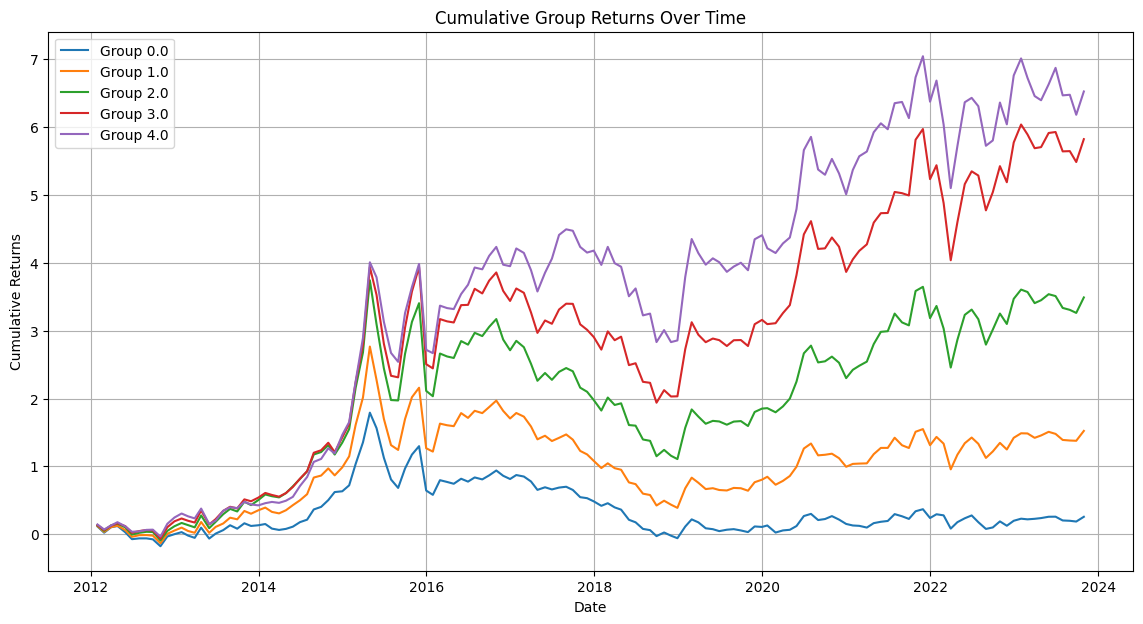

In [4]:
cumulative_returns = (1 + group_ret).cumprod() - 1

plt.figure(figsize=(14, 7))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=f'Group {column}')

plt.title('Cumulative Group Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# 计算年化收益率
annualized_returns = cumulative_returns.iloc[-1] ** (12 / len(cumulative_returns)) - 1
annualized_returns

group_id
0.0   -0.108621
1.0    0.036175
2.0    0.111412
3.0    0.160553
4.0    0.171782
Name: 2023-10-31 00:00:00, dtype: float64